## 2. Redes Convolucionales sobre imágenes

> a) Construya funciones para leer los datos y cargarlos al momento de entrenar (durante cada *epoch*), para ésto utilice *Image Data Generator* de keras.

In [31]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255) #no transformation
train_generator = train_datagen.flow_from_directory(
        'food_data/train',
        target_size=(150, 150),
        color_mode='rgb',
        batch_size=32)
validation_generator = test_datagen.flow_from_directory(
        'food_data/val',
        target_size=(150, 150),
        color_mode='rgb',
        batch_size=32)

Found 2600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


Se utiliza Keras para generar datos extras (image augmentation), rescalando, transveccionando y rotando.

>b) Utilice la red tradicional (Feed Forward) entregada en el código para ser entrenada sobre los datos vectorizados, esto es que cada imagen queda representada como un vector gigante, y las 3 clases a las que se enfrenta. Evalúe el modelo con la métrica accuracy sobre el conjunto de validación.


In [3]:
from keras.models import Sequential
from keras.layers import *
model = Sequential()
model.add(Flatten(input_shape=train_generator.image_shape)) #full dense
model.add(BatchNormalization()) #to normalize the input..
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu')) #128
model.add(Dropout(0.25))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # Let's train the model using RMSprop
model.summary()
model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator.classes)//train_generator.batch_size, #samples//batch_size
        epochs=25,
        validation_data=validation_generator,
        validation_steps=len(validation_generator.classes)//validation_generator.batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 67500)             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 67500)             270000    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               17280256  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 387       
Total para

In [4]:

print("Accuracy validation: ",model.evaluate_generator(generator=validation_generator)[1])

Accuracy validation:  0.4499999996026357


La red entrenada tiene una estructura de neuronas 67500x256x128x3, con capas dropout entre medio. Se utiliza el optimizador RMSPror, que es una variacion del SGD donde se actualiza el learning rate. Con un accurracy de 0.45 el modelo no discrimina correctamente las clases, lo mas probable es que la representacion vectorial de los datos elimina mucha informacion en la composicion de la imagen. Para arreglar esto se utiliza una red convolucional 

In [13]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = (cm.max()+cm.min())/ 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

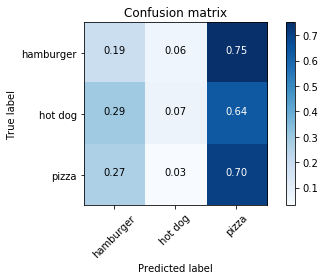

In [14]:
from sklearn.metrics import confusion_matrix 
Y_pred = model.predict_generator(validation_generator,len(validation_generator.classes)//validation_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(validation_generator.classes, y_pred)
plot_confusion_matrix(cm,["hamburger", "hot dog","pizza" ],normalize=True)

Analizando la matriz de confusion, esta claro que la red sobreestima las ocurrencias de pizzas, prediciendo que el hay una probabilidad de 70% (en ves de 33%) de que una imagen aleatoria este en esa clase, y subestima absolutamente la de los completos, lo mas probable es debido a la distribucion de colores dentro de este tipo de imagenes implique la clase de las pizzas se "coma" la clase de los completos. 

>c) Utilice la red convolucional (CNN) entregada en el código para ser entrenada sobre los datos brutos, matrices RGB de píxeles, y las 3 clases a las que se enfrenta. Evalúe el modelo con la métrica accuracy sobre el conjunto de validación. Compare.

In [32]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=train_generator.image_shape,activation='relu'))
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(len(train_generator.class_indices),activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # Let's train the model using RMSprop
model.summary()
model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator.classes)//train_generator.batch_size, #samples//batch_size
        epochs=25,
        validation_data=validation_generator,
        validation_steps=len(validation_generator.classes)//validation_generator.batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 148, 148, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 74, 74, 64)        18496     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
__________

In [34]:
print("Accuracy validation: ",model.evaluate_generator(generator=validation_generator)[1])

Accuracy validation:  0.698333334128062


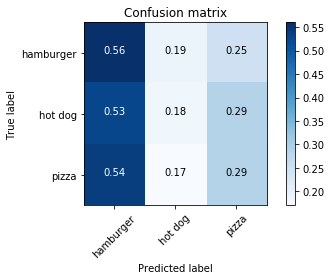

In [39]:
Y_pred = model.predict_generator(validation_generator,len(validation_generator.classes)//validation_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(validation_generator.classes, y_pred)
plot_confusion_matrix(cm,["hamburger", "hot dog","pizza" ],normalize=True)

Se obtiene un accurracy en el conjunto de validacion de 0.69, un aumento substancial de 24 puntos en comparacion al utilizar la representacion vectorial tradicional. Para este caso la red sobreestima la clase de las hamburgesas, dando una probabilidad de que una imagen sea de esta clase de 54%. Por otro lado, la matriz tiene una forma de "tres barras verticales", es decir, no depende tanto la etiqueta real la decision que toma la red.

>d) Genere un conjunto datos con incorrecta etiquetación de manera manual y vea si el modelo convolucional se sigue comportando de la misma manera. Para esto tome 100 imágenes aleatorias de entrenamiento de la carpeta hot dog y 100 imágenes aleatorias de entrenamiento de la carpeta hamburger e intercambielas, sin manipular las imágenes de la carpeta pizza y con el conjunto de validación intacto. Genere las matrices de confusión en el conjunto de validación para visualizar cómo afectó al modelo la corrupción realizada a los datos.

Para esta parte se intercambiaron 100 imagenes del conjunto de entrenamineto entre las clases hot dog y hamburger.

In [22]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255) #no transformation
train_generator = train_datagen.flow_from_directory(
        'food_data/train',
        target_size=(150, 150),
        color_mode='rgb',
        batch_size=32)
validation_generator = test_datagen.flow_from_directory(
        'food_data/val',
        target_size=(150, 150),
        color_mode='rgb',
        batch_size=32)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [23]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=train_generator.image_shape,activation='relu'))
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(len(train_generator.class_indices),activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # Let's train the model using RMSprop
model.summary()
model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator.classes)//train_generator.batch_size, #samples//batch_size
        epochs=25,
        validation_data=validation_generator,
        validation_steps=len(validation_generator.classes)//validation_generator.batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 148, 148, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 74, 74, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
__________

In [24]:
print("Accuracy validation: ",model.evaluate_generator(generator=validation_generator)[1])

Accuracy validation:  0.6783333333333333


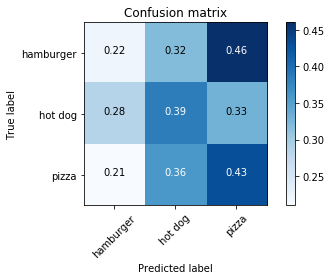

In [29]:

Y_pred = model.predict_generator(validation_generator,len(validation_generator.classes)//validation_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(validation_generator.classes, y_pred)
plot_confusion_matrix(cm,["hamburger", "hot dog","pizza" ],normalize=True)

Los resultados son levemente peores, una reduccion de 0.02 puntos de acurracy. De la matriz se aprecia que en la prediccion tiene un efecto la etiqueta real a diferencia de antes, pero a pesar de todo no hay un comportamiento significativo entre los completos y las hamburgesas. Se esperaba una especie de homogenizacion entre estas clases, cosa que la matriz representaria como una submatriz con cuatro valores cercanos. Sin embargo es importante destacar que las imagenes que se pedian discriminar eran de un tipo con bastantes elementos en comun, (colores, formas y contextos). 